# Notes for improvement

In [532]:
# Modify this to . Don't necessarily care about days. Collapse into 5 day (M=F) increments and repeat these over each month.
# Summarize average request time but overlay min and max/outliers.
# Use log scale with infinite deviation (for requests so long that something is wrong with the server)/cutoff point for extreme outliers.
# Three months of data for week view. Maybe month-by-month for 2 years. Total health history for all data.
# Make these time variables easy to modify by new users of this notebook.

# We will be giving this to clients. This will be a way to diagnose issues. This notebook will be logs, there wil be another for troubleshooting server issues.

# Might be able to get new data to test (WCN has 5 yrs).

# Prefer mean over average.

# Initial Setup

In [1]:
# Turn on inline display of plots in the notebook. (We should work on a more
# portable solution such as saving th plots to files down the road.)
%matplotlib inline

In [1]:
import pyodbc

## Create a connection function

In [2]:
# Connect via Windows authentication:
# conn_specs = ('DRIVER={ODBC Driver 17 for SQL Server};'
#                                     + 'SERVER=scotty-test;'
#                                     + 'DATABASE=Interject_Reporting;'
#                                    + 'trusted_connection=yes;')
# conn_str = 'mssql+pyodbc:///?odbc_connect={}'.format(conn_specs)
# engine = sqla.create_engine(conn_str)

# Define a function that we can use to connect to a db on the fly:
def pyodbc_connect_scotty_test(db_name):
    try:
        connection = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};'
                                        + 'SERVER=scotty-test;'
                                        + 'DATABASE=' + db_name + ';'
                                       + 'trusted_connection=yes;') # Windows auth
        return connection
    except:
        return 1 # could not connect

In [3]:
import pandas as pd

## Create a function to load requests data for specific years from SQL DB

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
reporting_conn = pyodbc_connect_scotty_test('Interject_Reporting')

Filter years to select data:

In [13]:
def read_requests_by_year(start_year: int, end_year: int) -> pd.DataFrame:
    # Convert start and end years to strings for comparion in the sql:
#     start_year_str = str(start_year)
#     end_year_str = str(end_year)
    
    # Select [EndTimeStamp] to mark the day, [Duration], from [Request] union with [Request_History] w/ SQL:
    from_req = 'SELECT [StartTimeStamp], datediff(second, [StartTimeStamp], [EndTimeStamp]) AS Duration FROM [test].[Request] r'
    union = ' UNION ALL'
    from_req_hist = ' SELECT [StartTimeStamp], datediff(second, [StartTimeStamp], [EndTimeStamp]) AS Duration FROM [test].[Request_History] rh'
#     where = ' WHERE r.[StartTimeStamp] LIKE "' + year + '*"' + ' AND rh.[StartTimeStamp] LIKE "' + year + '*"'
    where = ' WHERE (SUBSTRING(CONVERT(NVARCHAR(10), [StartTimeStamp], 102), 1, 4) BETWEEN ' + str(start_year) + ' AND ' + str(end_year) + ')'
#     and_where = ' AND (SUBSTRING(CONVERT(NVARCHAR(10), rh.[StartTimeStamp], 102), 1, 4) BETWEEN' + str(start_year) + ' AND ' + str(end_year) + ')'
    sql = from_req + union + from_req_hist + where
    requests = pd.read_sql(sql, reporting_conn, index_col='StartTimeStamp')
    
    return requests

## Create functions to reload the two basis DataFrames for the following plots

The DataFrames requests and requests_dates will be the basis DFs for which plots and other
DataFrames will be made in the remainder of this notebook.

**These functions should be called with their outputs set to *requests* and *requests_dates*
strictly, so that these variables are overwritten each time and not left in memory.**

In [14]:
def reload_requests_dataframe(start_year: int, end_year: int) -> pd.DataFrame:
    requests = read_requests_by_year(start_year, end_year)
    # Decrease memory usage for requests:
    requests['Duration'] = requests['Duration'].astype('float32')
    
    return requests

In [18]:
def reload_requests_dates_dataframe(start_year: int, end_year: int) -> pd.DataFrame:
    ''' Reload the requests_dates DataFrame for a new year range. Gives the option of passing
        in an existing instance of requests DF (must be from a call to reload_requests_dataframe())
        or, if dataframe=None, this function will instantiate a new basis requests DF. '''
    
    # BUGGGY:
#     if (dataframe is None):
#         requests_base = reload_requests_dataframe(start_year, end_year)
#         # Decrease memory usage for requests_base:
#         requests_base['Duration'] = requests_base['Duration'].astype('float32')
#     else:
#         requests_base = dataframe

    requests_base = reload_requests_dataframe(start_year, end_year)
    
    # Create DF of requests with useful dates columns:
    requests_dates = requests_base
    requests_dates['Year'] = requests_base.index.year
    requests_dates['Month'] = requests_base.index.month
    requests_dates['Week'] = requests_base.index.week
    requests_dates['Weekday'] = requests_base.index.weekday_name
    requests_dates['Day'] = requests_base.index.day
#     requests_dates.dropna(inplace=True)
    
    # Decrease memory usage for requests_dates:
    requests_dates[['Year', 'Month', 'Week', 'Day']] = requests_dates[['Year', 'Month', 'Week', 'Day']].astype('int16')
    
    return requests_dates

## Load intial data

**Rerun this cell with a new date range/s to RESET DATA:**

In [20]:
requests = reload_requests_dataframe(2018, 2019)
requests_dates = reload_requests_dates_dataframe(2018, 2019)

#### First look at requests DF

In [21]:
requests.head()

,Duration
StartTimeStamp,
2019-08-01 17:00:00.947,1.0
2019-08-01 17:00:21.560,18.0
2019-08-01 17:00:49.377,0.0
2019-08-01 17:01:07.030,15.0
2019-08-01 17:03:34.497,0.0


In [22]:
requests.describe()

,Duration
count,1.608257e+06
mean,1.891479e+00
std,1.314366e+01
min,-1.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,1.343400e+04


In [23]:
requests.isna().sum()

Duration    4622
dtype: int64

Verify types are small, as intended:

In [25]:
print(type(requests.index))
print(type(requests['Duration'][0]))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'numpy.float32'>


#### First look at requests_dates DF

In [24]:
requests_dates.head()

,Duration,Year,Month,Week,Weekday,Day
StartTimeStamp,,,,,,
2019-08-01 17:00:00.947,1.0,2019,8,31,Thursday,1
2019-08-01 17:00:21.560,18.0,2019,8,31,Thursday,1
2019-08-01 17:00:49.377,0.0,2019,8,31,Thursday,1
2019-08-01 17:01:07.030,15.0,2019,8,31,Thursday,1
2019-08-01 17:03:34.497,0.0,2019,8,31,Thursday,1


In [66]:
requests_dates.describe()

,Duration,Year,Month,Week,Day
count,1.608257e+06,1.608257e+06,1.608257e+06,1.608257e+06,1.608257e+06
mean,1.891479e+00,2.018331e+03,5.626664e+00,2.217515e+01,1.134353e+01
std,1.314366e+01,4.706673e-01,3.317209e+00,1.443448e+01,7.608449e+00
min,-1.000000e+00,2.018000e+03,1.000000e+00,1.000000e+00,1.000000e+00
25%,0.000000e+00,2.018000e+03,3.000000e+00,1.000000e+01,5.000000e+00
50%,1.000000e+00,2.018000e+03,5.000000e+00,2.000000e+01,9.000000e+00
75%,2.000000e+00,2.019000e+03,8.000000e+00,3.400000e+01,1.600000e+01
max,1.343400e+04,2.019000e+03,1.200000e+01,5.200000e+01,3.100000e+01


In [67]:
requests_dates.isna().sum()

Duration    0
Year        0
Month       0
Week        0
Weekday     0
Day         0
dtype: int64

Verify types are small, as intended:

In [26]:
print(type(requests_dates.index))
print(type(requests_dates['Duration'][0]))
print(type(requests_dates['Year'][0]))
print(type(requests_dates['Month'][0]))
print(type(requests_dates['Week'][0]))
print(type(requests_dates['Weekday'][0]))
print(type(requests_dates['Day'][0]))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'numpy.float32'>
<class 'numpy.int16'>
<class 'numpy.int16'>
<class 'numpy.int16'>
<class 'str'>
<class 'numpy.int16'>


## Initial Seaborn visualizations/mock ups

In [38]:
import seaborn as sns

#### Daily max request durations by weekday

NOTE: daily_max_request below is aggregating each distinct **day value** only. so 07/18/2015 and 06/18/2016 will be aggregated together...

In [467]:
# Create daily_max_request DF by grouping by day and aggregating the max:
daily_max_request = all_requests.groupby('Day').max()
daily_max_request = daily_max_request.rename(columns={'Duration':'Max_Duration'})
daily_max_request.head()

,Max_Duration,Year,Month,Week,Weekday
Day,,,,,
1,1.0,2015,2,5,Sunday
2,9.0,2015,2,6,Monday
3,40.0,2015,2,6,Tuesday
4,1.0,2015,2,6,Wednesday
5,187.0,2015,6,23,Thursday


In [468]:
# Check how many unique day values there are in all_requests (to verify our result above):
all_requests['Day'].nunique()

31

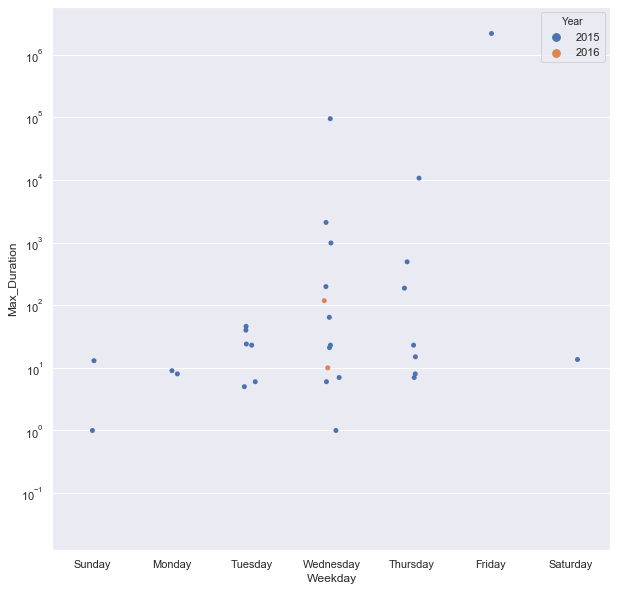

<Figure size 432x288 with 0 Axes>

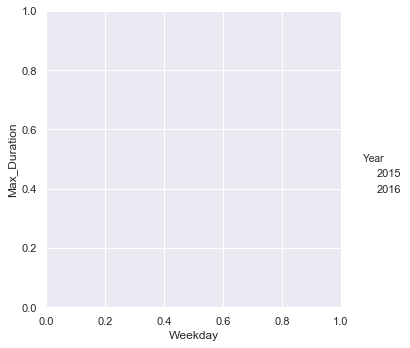

In [469]:
#--- Why do we have two graphs showing up here?
fig, ax = plt.subplots(figsize=(10,10))
plt.figure()
ax.set(yscale='log')
p = sns.catplot(x='Weekday', y='Max_Duration', hue='Year', data=daily_max_request, ax=ax)
plt.show()

# Day of the month instead of week, exclude sat/sun. Should see a pattern of spikes for first 7 day of the month.

# Add another variable, count of durations. Plot with amount of calls, overlay durations.

#### Durations by month

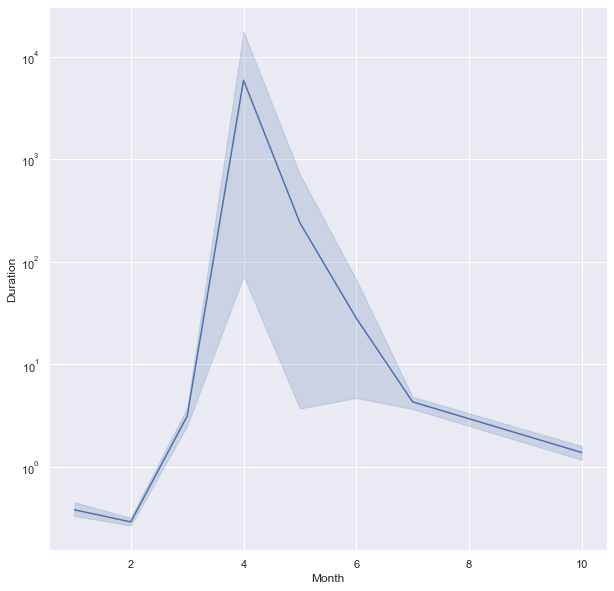

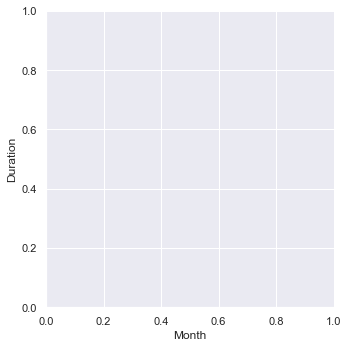

In [470]:
fig_dm, ax_dm = plt.subplots(figsize=(10,10))
sns.set(style='darkgrid')
ax_dm.set(yscale='log')
sns.relplot(x='Month', y='Duration', data=all_requests, ax=ax_dm, kind='line')

# Create some useful plotting helper functions

## Formatting functions:

#### Month name-number mapping for subplot (Axes) names

In [39]:
def place_month_names_on_axes(is_single_axes: bool, loc_str: str, font_size: int, dataframe: pd.DataFrame =None, axes_arr: list =None, ax: plt.Axes =None, df_month_col_name: str =None) -> None:

    # Create a dict of name-number pairs for month labeling:
    month_num_name = {
        1: 'January',
        2: 'February',
        3: 'March',
        4: 'April',
        5: 'May',
        6: 'June',
        7: 'July',
        8: 'August',
        9: 'September',
        10: 'October',
        11: 'November',
        12: 'December'
    }

    if (is_single_axes):
        month_number = dataframe[df_month_col_name].astype(int)[0]
        ax.set_title(month_num_name[month_number], loc=loc_str, fontsize=font_size, pad=10)
    else:
        for month in range(len(axes_arr)):
            # Extract the two characters that will contain the number:
            this_month_str = (axes[month].get_title())[-4] + (axes[month].get_title())[-3]
            # If the letter at position -4 from get_title() is a space, then it must have been a single-digit number in the name,
            # so extract it:
            if this_month_str[0] == ' ':
                this_month_num = int(this_month_str[1])
            else:
                this_month_num = int(this_month_str)
            # Change the title to the correct month name from the dict:
            axes[month].set_title(month_num_name[this_month_num], loc=loc_str, fontsize=font_size) # KNOWN BUG: sometimes this call will leave the old title in place.


#### Year title formatter for subplots (Axes) titles

In [40]:
def set_year_name_axes_titles(axes_arr, dataframe, loc_str):
    for year in range(dataframe['Year'].nunique()):
        current_title = axes[year].get_title()
#         axes[year].set_title(' ')
        new_title = current_title[7:11]
        axes[year].set_title(new_title, loc=loc, fontsize=16)

## Data filtration functions:

In [21]:
def drop_weekends(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Takes a dataframe (must contain a 'Weekday' column containing strings with weekday names) and returns a copy
    of that dataframe without any records observed on a weekend.
    '''
    weekday_filter = ( (dataframe['Weekday'] != 'Saturday') & (dataframe['Weekday'] != 'Sunday') )
    dataframe_no_weekends = dataframe.where(weekday_filter)
    dataframe_no_weekends = dataframe_no_weekends.dropna()
    return dataframe_no_weekends

In [41]:
# Test:
requests_dates_no_weekends = drop_weekends(requests_dates)
requests_dates_no_weekends.head()

,Duration,Year,Month,Week,Weekday,Day
StartTimeStamp,,,,,,
2019-08-01 17:00:00.947,1.0,2019.0,8.0,31.0,Thursday,1.0
2019-08-01 17:00:21.560,18.0,2019.0,8.0,31.0,Thursday,1.0
2019-08-01 17:00:49.377,0.0,2019.0,8.0,31.0,Thursday,1.0
2019-08-01 17:01:07.030,15.0,2019.0,8.0,31.0,Thursday,1.0
2019-08-01 17:03:34.497,0.0,2019.0,8.0,31.0,Thursday,1.0


## 1. Data over 1 year, by month

#### 1.1 - All request durations vs. mean estimation

In [111]:
# Known bugs:
    # -With fewer Axes, the figure looks bad (figure title overlaps first Axes, etc.). Need to make it dynamically styled. See fig.subplots_adjust() call.

In [112]:
# Make labels readable. Exclude weekends. Exclude holidays? Make if very obvious that we are excluding thesedays, make this reversible.

DataFrame prep:

In [18]:
def prep_data_1(base_data_w_dates: pd.DataFrame, year: int, exclude_weekends: bool) -> pd.DataFrame:

    year_filter = ( base_data_w_dates['Year'] == year )
    all_requests_year = base_data_w_dates.where(year_filter)
    all_requests_year.dropna(inplace=True)
    
    if (exclude_weekends):
        all_requests_year = drop_weekends(all_requests_year)
        
    return all_requests_year

**Load or reload data:**

In [20]:
all_requests_year = prep_data_1(
    base_data_w_dates = all_requests_dates,
    year=2015,
    exclude_weekends=False
)

MemoryError: 

In [19]:
all_requests_year.head()

,Duration,Year,Month,Week,Weekday,Day
StartTimeStamp,,,,,,
2018-10-27 17:01:14.660,1.0,2018.0,10.0,43.0,Saturday,27.0
2018-10-27 17:08:31.460,1.0,2018.0,10.0,43.0,Saturday,27.0
2018-10-27 17:08:33.530,0.0,2018.0,10.0,43.0,Saturday,27.0
2018-10-27 17:08:34.780,0.0,2018.0,10.0,43.0,Saturday,27.0
2018-10-27 17:10:34.880,1.0,2018.0,10.0,43.0,Saturday,27.0


**Alter figure appearance variables:**

In [20]:
all_data_line_color_1_1 = 'steelblue'
mean_data_line_color_1_1 = 'lightcoral'

#### Figure source code

In [21]:
import seaborn as sns

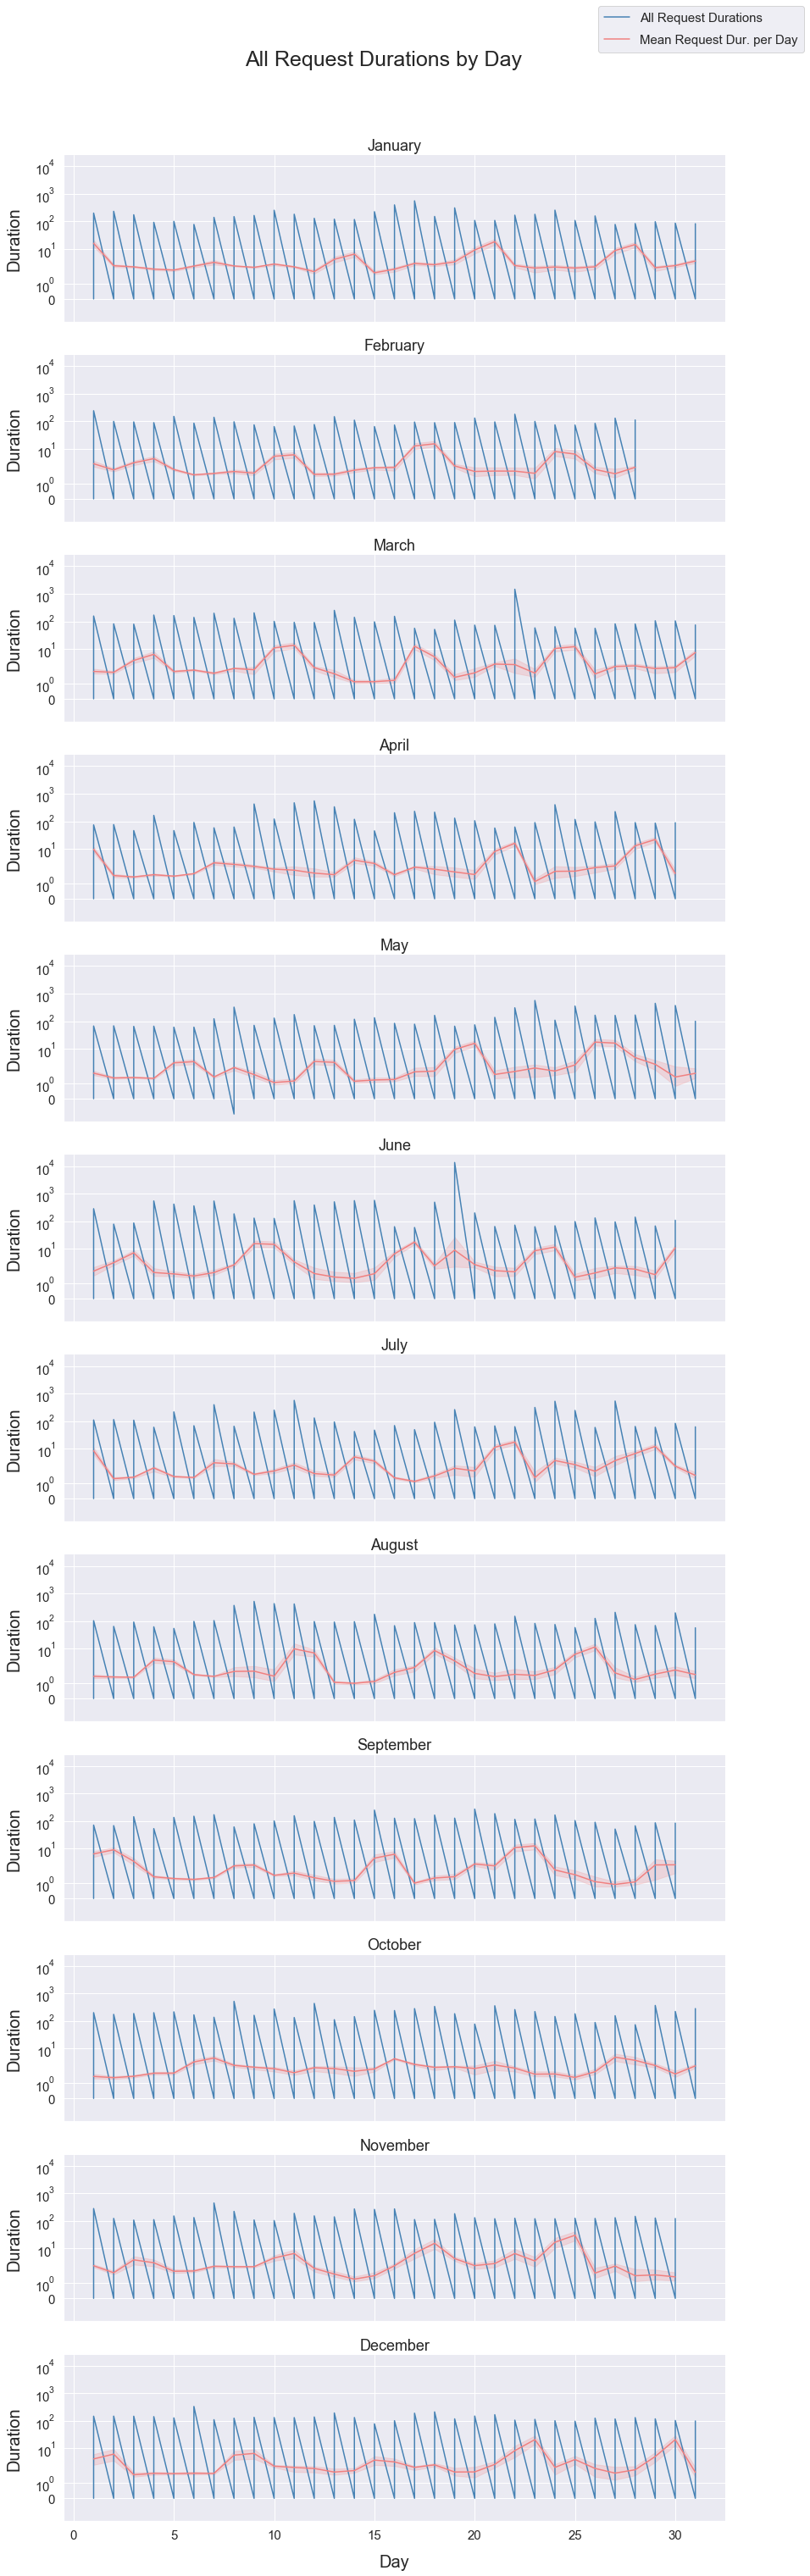

In [22]:
sns.set(style='darkgrid')

month_grid = sns.FacetGrid(all_requests_year, row='Month', height=3.5, aspect=4, legend_out=True)

# All observations:
month_grid.map(sns.lineplot, 'Day', 'Duration', estimator=None, color=all_data_line_color_1_1)
# Mean for each day:
month_grid.map(sns.lineplot, 'Day', 'Duration', estimator='mean', color=mean_data_line_color_1_1)

# Set figure aesthetics:

month_grid.fig.suptitle('All Request Durations by Day', fontsize=25)

month_grid.set_ylabels('Duration', fontsize=20, labelpad=15)
month_grid.set_xlabels('Day', fontsize=20, labelpad=15)

axes = month_grid.axes.flatten() # Numpy flatten 2D array of axes to array or 1D rows.
place_month_names_on_axes(is_single_axes=False, axes_arr=axes, loc_str='center', font_size=18)

month_grid.set(yscale='symlog')  # Retain zero values
# ax.set_ylim(bottom=-0.25)  # 0 doesn't work... 

# Settings that need to be applied to each axis:
for i in range(len(axes)):
    axes[i].tick_params(axis='both', which='major', labelsize=15)

# Set a figure-level legend with the lines (0 and 1) from the first ([0]) Axes (can do this b/c because all Axes have the same two lines):
month_grid.fig.legend(handles=(axes[0].lines[0], axes[0].lines[1]), labels=('All Request Durations', 'Mean Request Dur. per Day'), borderpad=0.5, labelspacing=0.8, fontsize=15, loc='upper right')

month_grid.fig.subplots_adjust(top=0.939, left=0.125, right=0.9, hspace=0.2, wspace=0.2)  # These are magic numbers, do not adjust.

# month_grid.add_legend(['All Request Durations', 'Mean Request Dur. per Day'])

# month_grid.set_xticklabels('')


As opposed to **this**:

In [ ]:
# Hanlde these errors. Handle errors for nulls in all of the code.

In [ ]:
grouped_months = all_requests.groupby('Month')
# for name, group in grouped_months:
#     print(name)
#     print(group)

# Some months have no data, exclude these:
all_requests_jan = grouped_months.get_group(1)
all_requests_feb = grouped_months.get_group(2)
all_requests_mar = grouped_months.get_group(3)
all_requests_apr = grouped_months.get_group(4)
all_requests_may = grouped_months.get_group(5)
all_requests_jun = grouped_months.get_group(6)
all_requests_jul = grouped_months.get_group(7)
#all_requests_aug = grouped_months.get_group(8)
# all_requests_sep = grouped_months.get_group(9)
all_requests_oct = grouped_months.get_group(10)
# all_requests_nov = grouped_months.get_group(11)
# all_requests_dec = grouped_months.get_group(12)

In [ ]:
#--- Make this more concise?
fig_months, axes = plt.subplots(12, 1, figsize=(25,30), sharex='all')
sns.lineplot(x='Day', y='Duration', data=all_requests_jan, ax=axes[0]).set(title="January")
sns.lineplot(x='Day', y='Duration', data=all_requests_feb, ax=axes[1])
sns.lineplot(x='Day', y='Duration', data=all_requests_mar, ax=axes[2])
sns.lineplot(x='Day', y='Duration', data=all_requests_apr, ax=axes[3])
sns.lineplot(x='Day', y='Duration', data=all_requests_may, ax=axes[4])
sns.lineplot(x='Day', y='Duration', data=all_requests_jun, ax=axes[5])
sns.lineplot(x='Day', y='Duration', data=all_requests_jul, ax=axes[6])
#sns.lineplot(x='Day', y='Duration', data=all_requests_aug, ax=axes[7])
#sns.lineplot(x='Day', y='Duration', data=all_requests_sep, ax=axes[8])
sns.lineplot(x='Day', y='Duration', data=all_requests_oct, ax=axes[9])
#sns.lineplot(x='Day', y='Duration', data=all_requests_nov, ax=axes[10])
#sns.lineplot(x='Day', y='Duration', data=all_requests_dec, ax=axes[11])`

## 2. Microscopic view of a single month

#### 2.1 - All request duration data vs. mean estimation by day, for a single month

DataFrame prep:

In [23]:
def prep_data_2_1(base_data_w_dates: pd.DataFrame, month: int, year: int):
    single_month_filter = ( ( base_data_w_dates['Year'] == year ) & ( base_data_w_dates['Month'] == month ) )
    all_requests_single_month = base_data_w_dates.where(single_month_filter)
    all_requests_single_month.dropna(inplace=True)
    all_requests_single_month.head()
    
    return all_requests_single_month

**Load or reload data:**

In [24]:
all_requests_single_month = prep_data_2_1(
    base_data_w_dates=all_requests_dates,
    month=12,
    year=2018)

In [25]:
all_requests_single_month.head()

,Duration,Year,Month,Week,Weekday,Day
StartTimeStamp,,,,,,
2018-12-05 17:18:01.967,1.0,2018.0,12.0,49.0,Wednesday,5.0
2018-12-05 17:18:03.527,3.0,2018.0,12.0,49.0,Wednesday,5.0
2018-12-05 17:18:07.393,2.0,2018.0,12.0,49.0,Wednesday,5.0
2018-12-05 17:18:07.813,2.0,2018.0,12.0,49.0,Wednesday,5.0
2018-12-05 17:18:09.587,0.0,2018.0,12.0,49.0,Wednesday,5.0


**Alter figure appearance variables:**

In [29]:
all_req_line_color_2_1 = 'steelblue'
mean_line_color_2_1 = 'lightcoral'

# Use this as a padding below 0 (we should not have any values under 0):
lower_y_lim_2_1 = -0.15

# Use this as the max request time that will be shown on the plot (as to not skew the plot toward ridiculously high values):
upper_y_lim_2_1 = 1000

(-0.15, 1000)

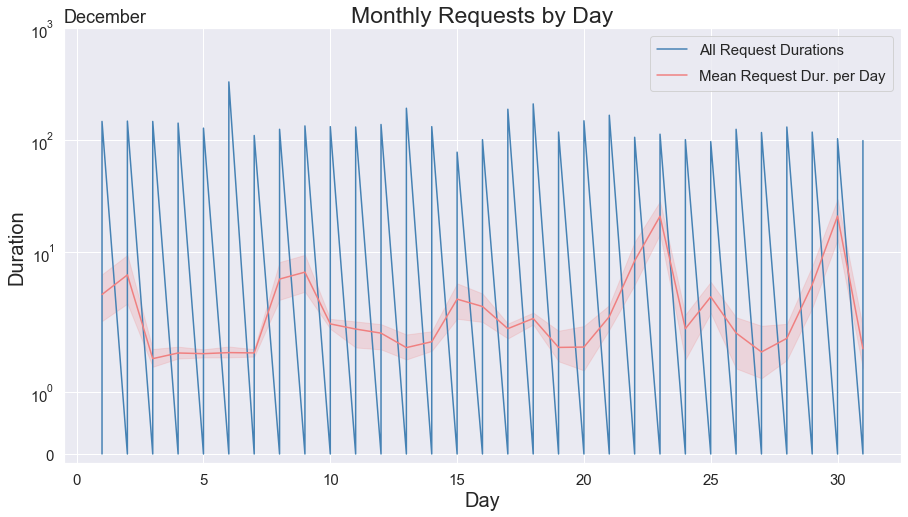

In [30]:
fig, ax = plt.subplots(figsize=(15,8))
sns.set(style='darkgrid')
# sns.scatterplot(x='StartTimeStamp', y='Duration', data=all_requests_single_month.reset_index())
sns.lineplot(x='Day', y='Duration', data=all_requests_single_month, estimator=None, color=all_req_line_color_2_1, ax=ax)
sns.lineplot(x='Day', y='Duration', data=all_requests_single_month, estimator='mean', color=mean_line_color_2_1, ax=ax)

place_month_names_on_axes(dataframe=all_requests_single_month, loc_str='left', font_size=18, is_single_axes=True, ax=ax, df_month_col_name='Month')

ax.set_title('Monthly Requests by Day', fontsize=23) # Change to "'January' Requests by Day"

ax.set_ylabel('Duration', fontsize=20)
ax.set_xlabel('Day', fontsize=20)

ax.legend(handles=(ax.lines[0], ax.lines[1]), labels=('All Request Durations', 'Mean Request Dur. per Day'), borderpad=0.5, labelspacing=0.8, fontsize=15, loc='upper right')

ax.tick_params(axis='both', which='major', labelsize=15)
# ax.set_xticklabels(all_requests_single_month['Day'])  # Can't use this because it's taking it as a list of EACH day entry in the DF, and lineplot is aggregating day values.
ax.set_yscale('symlog')
ax.set_ylim([lower_y_lim_2_1, upper_y_lim_2_1])

#### 2.2 - Monthly stats aggregated per day

In [45]:
def prep_data_daily_stats_2_2(base_data_w_dates: pd.DataFrame, month: int, year: int, exclude_weekends: bool):
    # Select only month and year specified:
    month_filter = ( (base_data_w_dates['Month'] == month) & (base_data_w_dates['Year'] == year) ) # Boolean series
    base_data_month = base_data_w_dates.where(month_filter)
    base_data_month.dropna(inplace=True)
    
    # Exclude weekends:
    if (exclude_weekends):
        weekday_filter = ( (base_data_month['Weekday'] != 'Saturday') & (base_data_month['Weekday'] != 'Sunday') )
        base_data_month.where(weekday_filter, inplace=True)
        base_data_month.dropna(inplace=True)
        
    day_aggs = base_data_month.groupby(pd.Grouper(freq='D')).agg(
    Min_Duration=pd.NamedAgg(column='Duration', aggfunc='min'),
    Max_Duration=pd.NamedAgg(column='Duration', aggfunc='max'),
    Mean_Duration=pd.NamedAgg(column='Duration', aggfunc=np.mean),
    Count_Durations=pd.NamedAgg(column='Duration', aggfunc='count'),
    Day=pd.NamedAgg(column='Day', aggfunc='max'),
    Month=pd.NamedAgg(column='Month', aggfunc='max')
#     Weekday=pd.NamedAgg(column='Duration', aggfunc=np.first)
    )
    
    day_aggs.dropna(inplace=True)

    return day_aggs

In [46]:
daily_stats_month = prep_data_daily_stats_2_2(
    base_data_w_dates=all_requests_dates,
    month=2,
    year=2015,
    exclude_weekends=True
)

In [47]:
daily_stats_month.head()

,Min_Duration,Max_Duration,Mean_Duration,Count_Durations,Day,Month
StartTimeStamp,,,,,,
2015-02-02,0.0,9.0,0.264368,2088,2.0,2.0
2015-02-03,0.0,40.0,0.330986,1136,3.0,2.0
2015-02-04,0.0,1.0,0.252212,452,4.0,2.0
2015-02-05,0.0,1.0,0.232639,288,5.0,2.0
2015-02-06,0.0,1.0,0.252078,361,6.0,2.0


**Alter figure appearance variables:**

In [50]:
marker_size_2_2 = 60

mean_line_color_2_2 = '#ffaa00'
max_line_color_2_2 = '#bb311b'
min_line_color_2_2 = '#54b536'
count_line_color_2_2 = '#224B8B'

# Use this as a padding below 0 (we should not have any values under 0):
lower_y_lim = -0.15

# Use this as the max request time that will be shown on the plot (as to not skew the plot toward ridiculously high values):
upper_y_lim = 10000

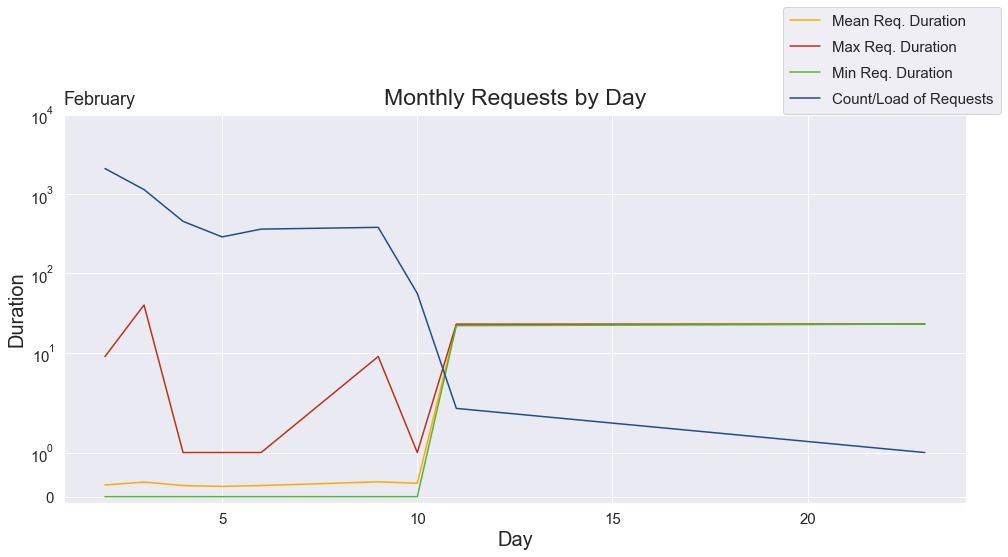

In [51]:
fig, ax = plt.subplots(figsize=(15,8))
sns.set(style='darkgrid')
# sns.scatterplot(x='StartTimeStamp', y='Duration', data=all_requests_single_month.reset_index())
sns.lineplot(x='Day', y='Mean_Duration', data=daily_stats_month, estimator=None, color=mean_line_color_2_2)
sns.lineplot(x='Day', y='Max_Duration', data=daily_stats_month, estimator=None, color=max_line_color_2_2)
sns.lineplot(x='Day', y='Min_Duration', data=daily_stats_month, estimator=None, color=min_line_color_2_2)
sns.lineplot(x='Day', y='Count_Durations', data=daily_stats_month, estimator=None, color=count_line_color_2_2)

ax.set_title('Monthly Requests by Day', fontsize=23) # Change to "'January' Requests by Day"

place_month_names_on_axes(dataframe=daily_stats_month, loc_str='left', font_size=18, is_single_axes=True, ax=ax, df_month_col_name='Month')

ax.set_ylabel('Duration', fontsize=20)
ax.set_xlabel('Day', fontsize=20)

fig.legend(handles=(ax.lines[0], ax.lines[1], ax.lines[2], ax.lines[3]), labels=('Mean Req. Duration', 'Max Req. Duration', 'Min Req. Duration', 'Count/Load of Requests', ), borderpad=0.5, labelspacing=0.8, fontsize=15, loc='upper right')

ax.tick_params(axis='both', which='major', labelsize=15)
# ax.set_xticklabels(all_requests_single_month['Day'])  # Can't use this because it's taking it as a list of EACH day entry in the DF, and lineplot is aggregating day values.
ax.set_yscale('symlog')
ax.set_ylim([lower_y_lim, upper_y_lim])

fig.subplots_adjust(top=0.8, left=0.125, right=0.96, hspace=0.2, wspace=0.2)  # These are magic numbers, do not adjust.

## 3. Analysis of request durations and load over 3 months

Consider eliminating months that we don't need in sql...

Data prep:

In [114]:
def prep_base_data_sect_3(base_data_w_dates: pd.DataFrame, start_month: int, end_month: int, year: int, exclude_weekends: bool) -> list:
   
    # Select only month and year specified:
    month_filter = ( (base_data_w_dates['Month'] >= start_month) & (base_data_w_dates['Month'] <= end_month) & (base_data_w_dates['Year'] == year) ) # Boolean series
    all_requests_3_mo = base_data_w_dates.where(month_filter)
    all_requests_3_mo.dropna(inplace=True)
    
    # Exclude weekends:
    if (exclude_weekends):
        weekday_filter = ( (all_requests_3_mo['Weekday'] != 'Saturday') & (all_requests_3_mo['Weekday'] != 'Sunday') )
        all_requests_3_mo.where(weekday_filter, inplace=True)
        all_requests_3_mo.dropna(inplace=True)

    return all_requests_3_mo

In [115]:
def prep_weekly_agg_data_sect_3(base_data_3_mo: pd.DataFrame) -> pd.DataFrame:
    
    # Aggregate Duration for min, max and count over each week (using named aggregation, which drops all non-aggregated, non-index cols):
    week_aggs = all_requests_3_mo.groupby('Week', as_index=True).agg(
    Min_Duration=pd.NamedAgg(column='Duration', aggfunc='min'),
    Max_Duration=pd.NamedAgg(column='Duration', aggfunc='max'),
#     Mean_Duration=pd.NamedAgg(column='Duration', aggfunc=np.mean),
    Count_Durations=pd.NamedAgg(column='Duration', aggfunc='count'),
    First_Day=pd.NamedAgg(column='Day', aggfunc='min'),
    Last_Day=pd.NamedAgg(column='Day', aggfunc='max')
#     Weekday=pd.NamedAgg(column='Duration', aggfunc=np.first)
    )
    
    # Do the last aggregation that was left our above with a simple groupby() and save in a second dataframe:
    week_agg_mean = all_requests_3_mo.groupby('Week', as_index=True).mean()
    week_agg_mean = week_agg_mean.rename(columns={'Duration':'Mean_Duration'})
    week_agg_mean.drop(axis=1, columns=['Day'], inplace=True)
    week_agg_mean.dropna(inplace=True) # use this form elsewhere!
    
    # Now there are 2 DFs that need to merge:
    dur_stats_3_mon_by_wk = pd.merge(week_aggs, week_agg_mean, on='Week')
    # Add a "Week_Label" column that can be used as a label for the plot, describing the month and the day-range of the given week:
    dur_stats_3_mon_by_wk['Week_Label'] = dur_stats_3_mon_by_wk['Year'].astype(int).astype(str) + '/' + dur_stats_3_mon_by_wk['Month'].astype(int).astype(str) + '\ndays: ' + dur_stats_3_mon_by_wk['First_Day'].astype(int).astype(str) + '-' + dur_stats_3_mon_by_wk['Last_Day'].astype(int).astype(str)
    # Drop columns that we only needed temporarily, to create the Week_Label above:
    dur_stats_3_mon_by_wk.drop(axis=1, columns=['First_Day', 'Last_Day', 'Year', 'Month'], inplace=True)

    # Lastly, reset the indexes for both final DFs back to the default integer index, so that the 'Week' column can be used by plotting functions without complaints:
    dur_stats_3_mon_by_wk.reset_index(inplace=True)
#     longform_dur_stats_3_mon_by_wk.reset_index(inplace=True)
        
    return dur_stats_3_mon_by_wk

#### 3.1 - Lineplots of weekly request data, over 3 months

**Load or reload data:**

In [116]:
# RUN THIS CELL TO RESET DATA:
all_requests_3_mo = prep_base_data_sect_3(
    base_data_w_dates=all_requests_dates,
    start_month=1,
    end_month=3,
    year=2015,
    exclude_weekends=True)

dur_stats_3_mo_wk = prep_weekly_agg_data_sect_3(all_requests_3_mo)

View the DataFrame that will be plotted:

In [117]:
dur_stats_3_mo_wk.head()

,Week,Min_Duration,Max_Duration,Count_Durations,Mean_Duration,Week_Label
0,4.0,0.0,4.0,32,0.625000,2015/1\ndays: 19-22
1,5.0,0.0,46.0,1474,0.388060,2015/1\ndays: 26-30
2,6.0,0.0,40.0,4325,0.277457,2015/2\ndays: 2-6
3,7.0,0.0,23.0,438,0.433790,2015/2\ndays: 9-11
4,9.0,23.0,23.0,1,23.000000,2015/2\ndays: 23-23


#### **Expand cells below to see intermediate results of the DataFrame manipulation above:**

##### Create 2 DFs, one w/ *most* aggs. for the week, one preserving other columns, then join

Idea for this approach:

In [262]:
# Need to preserve just the Week by using it as an index, then make another aggregated dataframe by week with
# all the columns then merge them on Week number.

1st DF - all aggregations by week that we need to do (except for mean)...

In [516]:
week_aggs = all_requests_3_mo.groupby('Week', as_index=True).agg(
    Min_Duration=pd.NamedAgg(column='Duration', aggfunc='min'),
    Max_Duration=pd.NamedAgg(column='Duration', aggfunc='max'),
#     Mean_Duration=pd.NamedAgg(column='Duration', aggfunc=np.mean),
    Count_Durations=pd.NamedAgg(column='Duration', aggfunc='count'),
    First_Day=pd.NamedAgg(column='Day', aggfunc='min'),
    Last_Day=pd.NamedAgg(column='Day', aggfunc='max')
#     Weekday=pd.NamedAgg(column='Duration', aggfunc=np.first)
)
week_aggs.head()

,Min_Duration,Max_Duration,Count_Durations,First_Day,Last_Day
Week,,,,,
4.0,0.0,4.0,32,19.0,22.0
5.0,0.0,46.0,1474,26.0,30.0
6.0,0.0,40.0,4325,2.0,6.0
7.0,0.0,23.0,438,9.0,11.0
9.0,23.0,23.0,1,23.0,23.0
11.0,3.0,5.0,4,14.0,15.0
13.0,0.0,22.0,87,23.0,26.0
14.0,0.0,1.0,3,30.0,30.0
15.0,0.0,10673.0,85,6.0,10.0


2nd DF - one aggregation w/ df.groupby() to preserve other columns:

In [520]:
week_agg_mean = all_requests_3_mo.groupby('Week', as_index=True).mean()
week_agg_mean = week_agg_mean.rename(columns={'Duration':'Mean_Duration'})
week_agg_mean.drop(axis=1, columns=['Day'], inplace=True)
week_agg_mean.dropna(inplace=True) # use this form elsewhere!
week_agg_mean.head()

,Mean_Duration,Year,Month
Week,,,
4.0,0.625000,2015.0,1.0
5.0,0.388060,2015.0,1.0
6.0,0.277457,2015.0,2.0
7.0,0.433790,2015.0,2.0
9.0,23.000000,2015.0,2.0
11.0,4.250000,2016.0,3.0
13.0,3.183908,2015.0,3.0
14.0,0.333333,2015.0,3.0
15.0,510.458824,2015.0,4.0


Join the two

In [521]:
dur_stats_3_mon_by_wk = pd.merge(week_aggs, week_agg_mean, on='Week')
# Add a "Week_Label" column that can be used as a label for the plot, describing the month and the day-range of the given week:
dur_stats_3_mon_by_wk['Week_Label'] = dur_stats_3_mon_by_wk['Year'].astype(int).astype(str) + '/' + dur_stats_3_mon_by_wk['Month'].astype(int).astype(str) + '\ndays: ' + dur_stats_3_mon_by_wk['First_Day'].astype(int).astype(str) + '-' + dur_stats_3_mon_by_wk['Last_Day'].astype(int).astype(str)
# Drop columns that we only needed temporarily, to create the Week_Label above:
dur_stats_3_mon_by_wk.drop(axis=1, columns=['First_Day', 'Last_Day', 'Year', 'Month'], inplace=True)
dur_stats_3_mon_by_wk.head()

,Min_Duration,Max_Duration,Count_Durations,Mean_Duration,Week_Label
Week,,,,,
4.0,0.0,4.0,32,0.625000,2015/1\ndays: 19-22
5.0,0.0,46.0,1474,0.388060,2015/1\ndays: 26-30
6.0,0.0,40.0,4325,0.277457,2015/2\ndays: 2-6
7.0,0.0,23.0,438,0.433790,2015/2\ndays: 9-11
9.0,23.0,23.0,1,23.000000,2015/2\ndays: 23-23
11.0,3.0,5.0,4,4.250000,2016/3\ndays: 14-15
13.0,0.0,22.0,87,3.183908,2015/3\ndays: 23-26
14.0,0.0,1.0,3,0.333333,2015/3\ndays: 30-30
15.0,0.0,10673.0,85,510.458824,2015/4\ndays: 6-10


finally...

Create a long-form ver. of dur_stats_3_mon_byto use categorical functionality of sns.swarmplot

In [519]:
# Unpivot:
longform_dur_stats_3_mon_by_wk = pd.melt(dur_stats_3_mon_by_wk.reset_index(), id_vars='Week', value_vars=['Min_Duration', 'Max_Duration', 'Mean_Duration', 'Count_Durations'], var_name='Dur_Stat_Type', value_name='Dur_Stat_Value')
longform_dur_stats_3_mon_by_wk = pd.merge(longform_dur_stats_3_mon_by_wk, dur_stats_3_mon_by_wk[['Week_Label']], how='left', on='Week') # Clean this up to only bring in columns we need.
# longform_dur_stats_3_mon_by_wk.drop(axis=1, columns=['Min_Duration', 'Max_Duration', 'Mean_Duration', 'Count_Durations', 'Year', 'Month', 'Day'], inplace=True)
longform_dur_stats_3_mon_by_wk.head()

,Week,Dur_Stat_Type,Dur_Stat_Value,Week_Label
0,4.0,Min_Duration,0.0,2015/1\ndays: 19-22
1,5.0,Min_Duration,0.0,2015/1\ndays: 26-30
2,6.0,Min_Duration,0.0,2015/2\ndays: 2-6
3,7.0,Min_Duration,0.0,2015/2\ndays: 9-11
4,9.0,Min_Duration,23.0,2015/2\ndays: 23-23


Reset the indexes on dur_stats_3_mon_by_wk and longform_dur_stats_3_mon_by_wk so that 'Week' can be easily referenced without doing df.index:

In [508]:
dur_stats_3_mon_by_wk.reset_index(inplace=True)
longform_dur_stats_3_mon_by_wk.reset_index(inplace=True)

##### 3.1.1 - Lineplot of mean request time vs. request load/count for each week

**Alter figure appearance variables:**

In [102]:
marker_size_3_1_1 = 150

mean_line_color_3_1_1 = '#3FAA75'
count_line_color_3_1_1 = '#AB1B53'

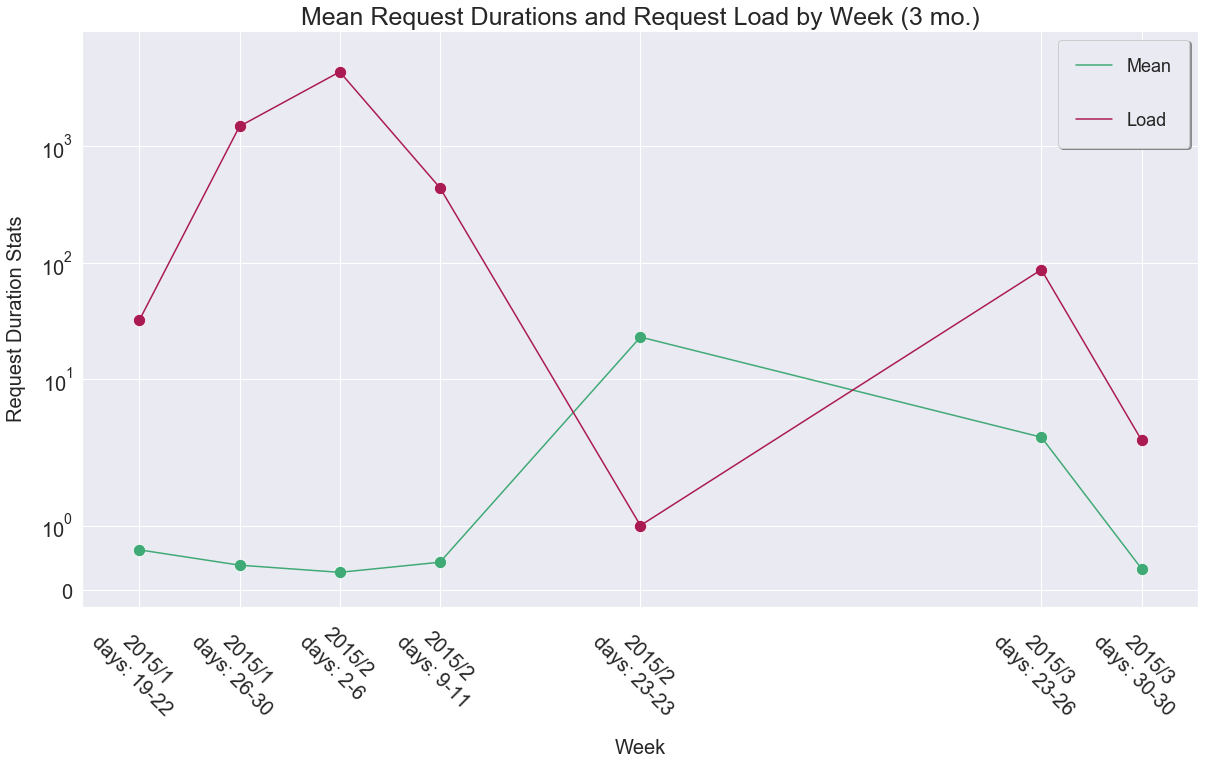

In [103]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(20,10))

# nice green: #3FAA75
sns.lineplot(x='Week', y='Mean_Duration', data=dur_stats_3_mo_wk, color=mean_line_color_3_1_1, ax=ax)
sns.scatterplot(x='Week', y='Mean_Duration', data=dur_stats_3_mo_wk, color=mean_line_color_3_1_1, s=marker_size_3_1_1, ax=ax)
sns.lineplot(x='Week', y='Count_Durations', data=dur_stats_3_mo_wk, color=count_line_color_3_1_1, ax=ax)
sns.scatterplot(x='Week', y='Count_Durations', data=dur_stats_3_mo_wk, color=count_line_color_3_1_1, s=marker_size_3_1_1, ax=ax)

fig.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.2, wspace=0.2) # This is magic code...

ax.set_yscale('symlog')  # Retain zero values
ax.set_ylim(bottom=-0.25)  # 0 doesn't work... 

ax.set_ylabel('Request Duration Stats', fontsize=20, labelpad=15)
ax.set_xlabel('Week', fontsize=20, labelpad=20)

ax.set_title('Mean Request Durations and Request Load by Week (3 mo.)', loc='center', fontsize=25)

ax.set_xticks(dur_stats_3_mo_wk['Week'])
ax.set_xticklabels(longform_dur_stats_3_mo_wk['Week_Label'], rotation=-45)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.legend(('Mean', 'Load'), borderpad=1, labelspacing=2, fontsize=18, shadow=True)

##### 3.1.2 - Lineplot of all weekly stats, over 3 months

**Alter figure appearance variables:**

In [104]:
marker_size_3_1_2 = 150

mean_line_color_3_1_2 = '#F7941D'
max_line_color_3_1_2 = '#DE3354'
min_line_color_3_1_2 = '#36B449'
count_line_color_3_1_2 = '#135A8E'

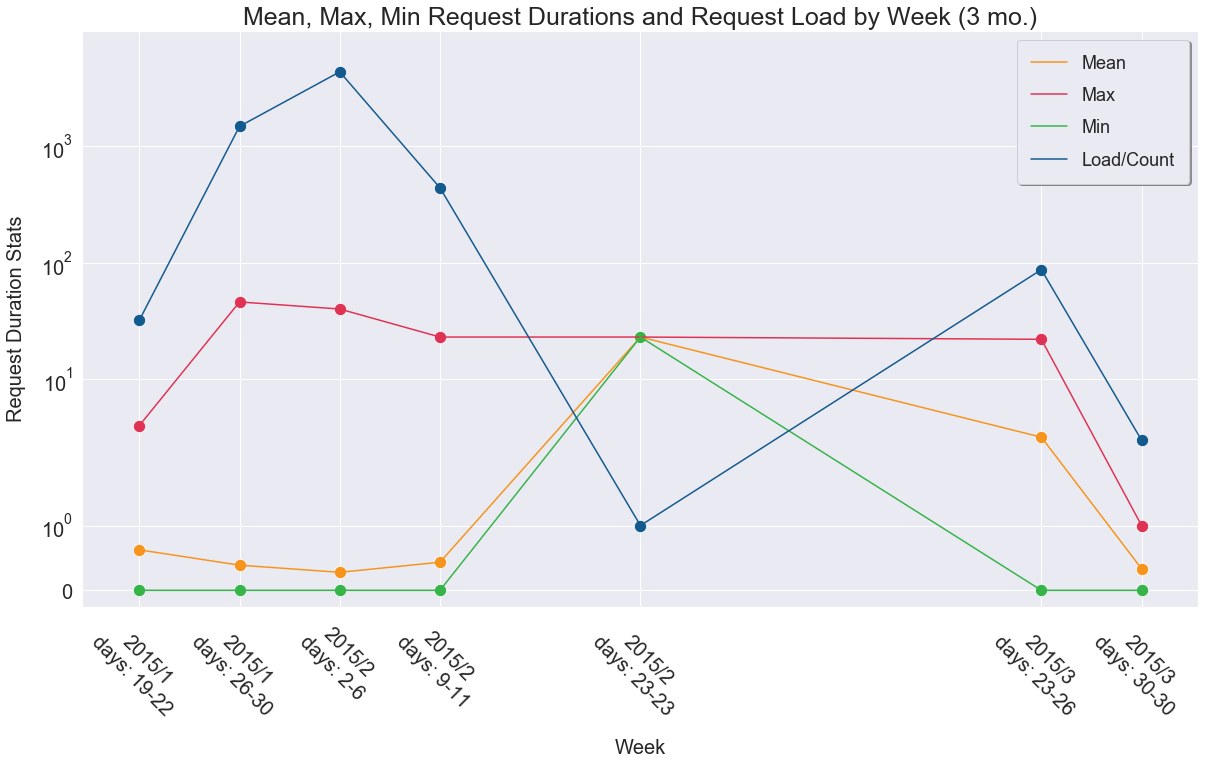

In [105]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(20,10))

# nice green: #3FAA75
sns.lineplot(x='Week', y='Mean_Duration', data=dur_stats_3_mo_wk, color=mean_line_color_3_1_2, ax=ax)
sns.scatterplot(x='Week', y='Mean_Duration', data=dur_stats_3_mo_wk, color=mean_line_color_3_1_2, s=marker_size_3_1_2, ax=ax)

sns.lineplot(x='Week', y='Max_Duration', data=dur_stats_3_mo_wk, color=max_line_color_3_1_2, ax=ax)
sns.scatterplot(x='Week', y='Max_Duration', data=dur_stats_3_mo_wk, color=max_line_color_3_1_2, s=marker_size_3_1_2, ax=ax)

sns.lineplot(x='Week', y='Min_Duration', data=dur_stats_3_mo_wk, color=min_line_color_3_1_2, ax=ax)
sns.scatterplot(x='Week', y='Min_Duration', data=dur_stats_3_mo_wk, color=min_line_color_3_1_2, s=marker_size_3_1_2, ax=ax)

sns.lineplot(x='Week', y='Count_Durations', data=dur_stats_3_mo_wk, color=count_line_color_3_1_2, ax=ax)
sns.scatterplot(x='Week', y='Count_Durations', data=dur_stats_3_mo_wk, color=count_line_color_3_1_2, s=marker_size_3_1_2, ax=ax)

fig.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.2, wspace=0.2) # This is magic code...

ax.set_yscale('symlog')  # Retain zero values
ax.set_ylim(bottom=-0.25)  # 0 doesn't work... 

ax.set_ylabel('Request Duration Stats', fontsize=20, labelpad=15)
ax.set_xlabel('Week', fontsize=20, labelpad=20)

ax.set_title('Mean, Max, Min Request Durations and Request Load by Week (3 mo.)', loc='center', fontsize=25)

ax.set_xticks(dur_stats_3_mo_wk['Week'])
ax.set_xticklabels(longform_dur_stats_3_mo_wk['Week_Label'], rotation=-45)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.legend((ax.lines[0], ax.lines[1], ax.lines[2], ax.lines[3]), ('Mean', 'Max', 'Min', 'Load/Count'), borderpad=0.8, labelspacing=0.8, fontsize=18, shadow=True)

#### 3.2 - Comparison of individual weekly stats, over 3 months

Data prep:

In [89]:
def prep_longform_weekly_agg_data_3_2(base_data_3_mo: pd.DataFrame) -> pd.DataFrame:
    base_data_agged_wk = prep_weekly_agg_data_sect_3(base_data_3_mo)
    
    # Create a long-form/unpivoted version of dur_stats_3_mon_by_wk that can be used with Seaborn's swarmplot:
    lf_dur_stats_3_mo_wk = pd.melt(base_data_agged_wk.reset_index(), id_vars='Week', value_vars=['Min_Duration', 'Max_Duration', 'Mean_Duration', 'Count_Durations'], var_name='Dur_Stat_Type', value_name='Dur_Stat_Value')
    lf_dur_stats_3_mo_wk = pd.merge(lf_dur_stats_3_mo_wk, base_data_agged_wk[['Week_Label', 'Week']], how='left', on='Week')
    # longform_dur_stats_3_mon_by_wk.drop(axis=1, columns=['Min_Duration', 'Max_Duration', 'Mean_Duration', 'Count_Durations', 'Year', 'Month', 'Day'], inplace=True)
    
    return lf_dur_stats_3_mo_wk

**Load/reload data:**

In [93]:
# RUN THIS CELL TO RESET DATA:
all_requests_3_mo = prep_base_data_sect_3(
    base_data_w_dates=all_requests_dates,
    start_month=1,
    end_month=3,
    year=2015,
    exclude_weekends=True)

lf_dur_stats_3_mo_wk = prep_longform_weekly_agg_data_3_2(all_requests_3_mo)

View the DataFrame that will be plotted:

In [94]:
lf_dur_stats_3_mo_wk.head()

,Week,Dur_Stat_Type,Dur_Stat_Value,Week_Label
0,4.0,Min_Duration,0.0,2015/1\ndays: 19-22
1,5.0,Min_Duration,0.0,2015/1\ndays: 26-30
2,6.0,Min_Duration,0.0,2015/2\ndays: 2-6
3,7.0,Min_Duration,0.0,2015/2\ndays: 9-11
4,9.0,Min_Duration,23.0,2015/2\ndays: 23-23


In [95]:
import seaborn as sns

**Alter figure appearance variables:**

In [123]:
marker_size_3_2 = 14

mean_line_color_3_2 = '#4d85bd'
max_line_color_3_2 = '#cb6318'
min_line_color_3_2 = '#f5e356'
count_line_color_3_2 = '#7caa2d'

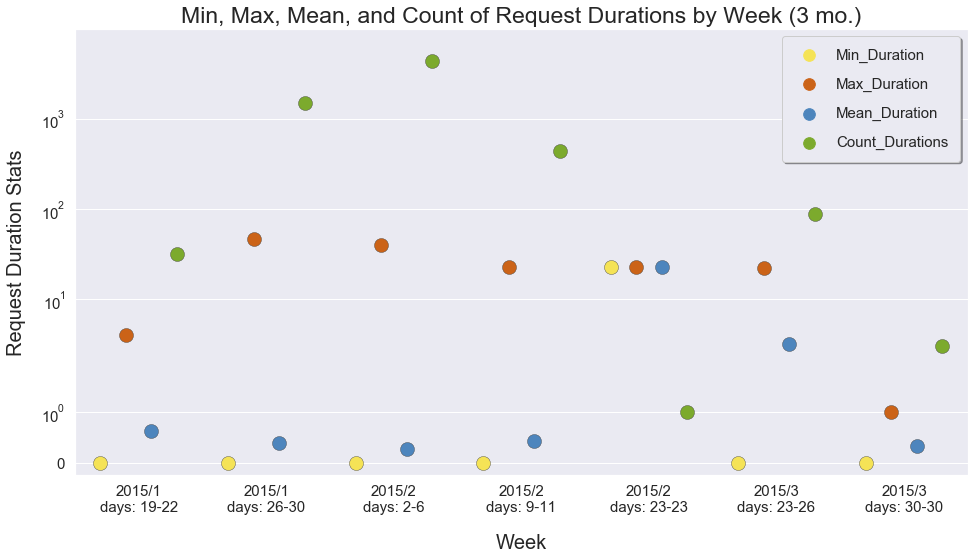

In [124]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(16,8))

# Good color schemes: https://www.schemecolor.com/bond-unknown.php, https://www.canva.com/learn/100-color-combinations/ number 23

colors = sns.color_palette((min_line_color_3_2, max_line_color_3_2, mean_line_color_3_2, count_line_color_3_2))  # MIN, MAX, MEAN, COUNT

sns.swarmplot(x='Week', y='Dur_Stat_Value', hue='Dur_Stat_Type', data=longform_dur_stats_3_mo_wk, dodge=True, edgecolor='gray', linewidth=.4, palette=colors, s=marker_size_3_2, ax=ax)
# sns.regplot(x='Week', y='Mean_Duration', data=dur_stats_3_mo_wk, color='#4d85bd', scatter_kws={'s': 0}, ax=ax)

plt.subplots_adjust(top=0.9)

ax.set_yscale('symlog')  # Retain zero values
ax.set_ylim(bottom=-0.25)

ax.set_ylabel('Request Duration Stats', fontsize=20, labelpad=15)
ax.set_xlabel('Week', fontsize=20, labelpad=19)
ax.set_title('Min, Max, Mean, and Count of Request Durations by Week (3 mo.)', loc='center', fontsize=23)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticklabels(longform_dur_stats_3_mo_wk['Week_Label'])

ax.legend(borderpad=0.8, labelspacing=1, fontsize=15, shadow=True, markerscale=1.5)

#### 3.3 - DAILY stats over 3 months

Fine-tuning done...
TO DO:
-Apply month-naming function and add Axes titles.

In [220]:
def prep_daily_agg_data_sect_3(base_data_3_mo_w_dates: pd.DataFrame) -> pd.DataFrame:
    
    # Aggregate 'Duration' for min, max, count:
    day_aggs = base_data_3_mo_w_dates.groupby(pd.Grouper(freq='D')).agg(
    Min_Duration=pd.NamedAgg(column='Duration', aggfunc='min'),
    Max_Duration=pd.NamedAgg(column='Duration', aggfunc='max'),
    Mean_Duration=pd.NamedAgg(column='Duration', aggfunc=np.mean),
    Count_Durations=pd.NamedAgg(column='Duration', aggfunc='count'),
    Day=pd.NamedAgg(column='Day', aggfunc='max'),
    Month=pd.NamedAgg(column='Month', aggfunc='max'),
    Year=pd.NamedAgg(column='Year', aggfunc='max')
    )
    
    day_aggs.dropna(inplace=True)
    
    # Add a "Day_Label" column that can be used as a label for the plot, describing the month day of the datapoint:
    day_aggs['Day_Label'] = day_aggs['Year'].astype(int).astype(str) + '/' + day_aggs['Month'].astype(int).astype(str) + '/' + day_aggs['Day'].astype(int).astype(str)

    day_aggs.sort_values(by=['Month', 'Day'], inplace=True)
    
    return day_aggs

##### 3.3.1 - Daily stats over 3-months, in single plot

**Load or reload data:**

In [221]:
# RUN THIS CELL TO RESET DATA:
all_requests_3_mo = prep_base_data_sect_3(
    all_requests_dates,
    start_month=1,
    end_month=3,
    year=2015,
    exclude_weekends=True)

dur_stats_3_mo_day = prep_daily_agg_data_sect_3(all_requests_3_mo)

View the DataFrame that will be plotted:

In [222]:
dur_stats_3_mo_day.head()

,Min_Duration,Max_Duration,Mean_Duration,Count_Durations,Day,Month,Year,Day_Label
StartTimeStamp,,,,,,,,
2015-01-19,0.0,4.0,0.655172,29,19.0,1.0,2015.0,2015/1/19
2015-01-22,0.0,1.0,0.333333,3,22.0,1.0,2015.0,2015/1/22
2015-01-26,0.0,46.0,5.555556,9,26.0,1.0,2015.0,2015/1/26
2015-01-27,0.0,2.0,0.333333,9,27.0,1.0,2015.0,2015/1/27
2015-01-28,0.0,5.0,1.010638,94,28.0,1.0,2015.0,2015/1/28


**Alter figure appearance variables:**

In [223]:
# marker_size_3_3_1 = 150

mean_line_color_3_3_1 = '#FBBC05'
max_line_color_3_3_1 = '#EA4335'
min_line_color_3_3_1 = '#34A853'
count_line_color_3_3_1 = '#4285F4'

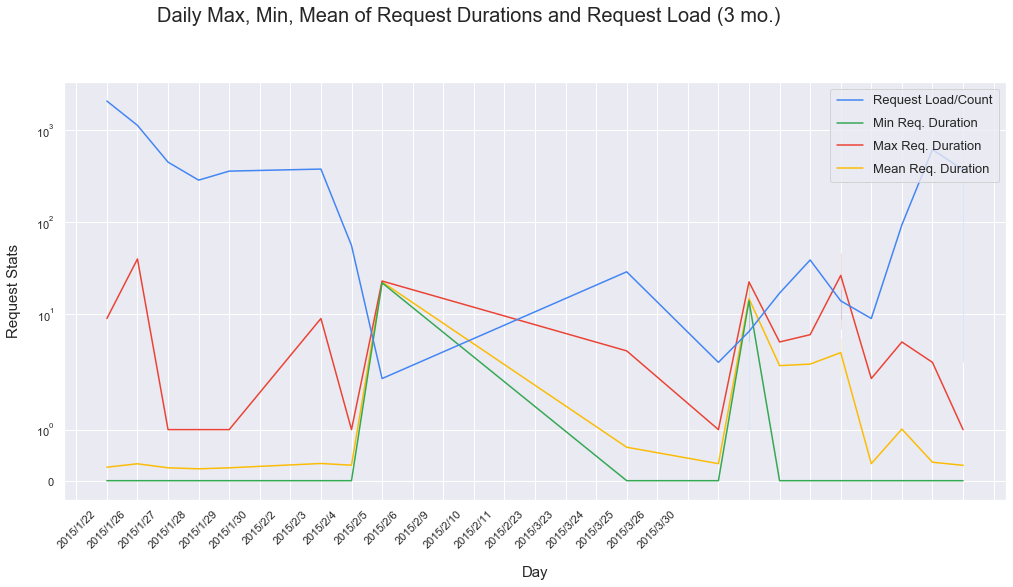

In [232]:
from matplotlib.ticker import IndexFormatter, MultipleLocator

fig, ax = plt.subplots(figsize=(15,8))

sns.lineplot(data=dur_stats_3_mo_day, x='Day', y='Mean_Duration', color=mean_line_color_3_3_1, ax=ax)
sns.lineplot(data=dur_stats_3_mo_day, x='Day', y='Max_Duration', color=max_line_color_3_3_1, ax=ax)
sns.lineplot(data=dur_stats_3_mo_day, x='Day', y='Min_Duration', color=min_line_color_3_3_1, ax=ax)
sns.lineplot(data=dur_stats_3_mo_day, x='Day', y='Count_Durations', color=count_line_color_3_3_1, ax=ax)

ax.set_ylabel('Request Stats', fontsize=15, labelpad=15)
ax.set_xlabel('Day', fontsize=15, labelpad=15)

ax.set(yscale='symlog')  # Retain zero values
# ax.set_ylim(bottom=-0.25)  # 0 doesn't work... 

# grid.set_titles(fontsize=200)

# grid.set_xticklabels('')

fig.subplots_adjust(top=0.85, left=0.125, right=0.997, hspace=0.2)  # These are magic numbers, do not adjust.
fig.suptitle('Daily Max, Min, Mean of Request Durations and Request Load (3 mo.)', fontsize=20)

ax.legend(handles=(ax.lines[3], ax.lines[2], ax.lines[1], ax.lines[0]), labels=('Request Load/Count', 'Min Req. Duration', 'Max Req. Duration', 'Mean Req. Duration'), borderpad=0.5, labelspacing=0.8, fontsize=13, loc='upper right')

# grid.axes[i].tick_params(axis='both', which='major', labelsize=15)
# ax.set_xticklabels(longform_dur_stats_3_mon_by_day['Day_Label'])

# ax.set_xticks(dur_stats_3_mo_day['Day'])
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(IndexFormatter(dur_stats_3_mo_day['Day_Label']))

ax.tick_params(axis='x', rotation=45)

##### 3.2 - Daily stats over 3 months, with plot for each month

View the DataFrame that will be plotted:

In [225]:
dur_stats_3_mo_day.head()

,Min_Duration,Max_Duration,Mean_Duration,Count_Durations,Day,Month,Year,Day_Label
StartTimeStamp,,,,,,,,
2015-01-19,0.0,4.0,0.655172,29,19.0,1.0,2015.0,2015/1/19
2015-01-22,0.0,1.0,0.333333,3,22.0,1.0,2015.0,2015/1/22
2015-01-26,0.0,46.0,5.555556,9,26.0,1.0,2015.0,2015/1/26
2015-01-27,0.0,2.0,0.333333,9,27.0,1.0,2015.0,2015/1/27
2015-01-28,0.0,5.0,1.010638,94,28.0,1.0,2015.0,2015/1/28


**Alter figure appearance variables:**

In [104]:
marker_size_3_1_2 = 150

mean_line_color_3_1_2 = '#F7941D'
max_line_color_3_1_2 = '#DE3354'
min_line_color_3_1_2 = '#36B449'
count_line_color_3_1_2 = '#135A8E'

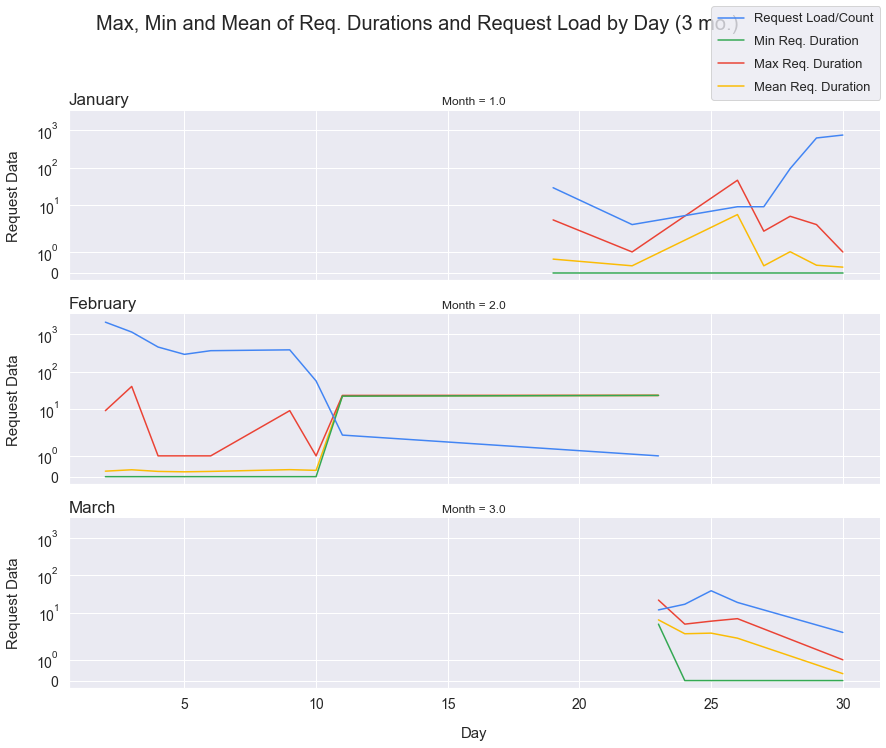

In [231]:
grid = sns.FacetGrid(row='Month', data=dur_stats_3_mo_day.reset_index(), height=3.4, aspect=3.8, legend_out=True)

grid.map(sns.lineplot, 'Day', 'Mean_Duration', color='#FBBC05')
grid.map(sns.lineplot, 'Day', 'Max_Duration', color='#EA4335')
grid.map(sns.lineplot, 'Day', 'Min_Duration', color='#34A853')
grid.map(sns.lineplot, 'Day', 'Count_Durations', color='#4285F4')

axes = grid.axes.flatten()

grid.set_ylabels('Request Data', fontsize=15, labelpad=15)
grid.set_xlabels('Day', fontsize=15, labelpad=15)

place_month_names_on_axes(is_single_axes=False, axes_arr=axes, loc_str='left', font_size=17)

grid.set(yscale='symlog')  # Retain zero values
# ax.set_ylim(bottom=-0.25)  # 0 doesn't work... 

grid.set_titles(fontsize=200)

# grid.set_xticklabels('')

grid.fig.subplots_adjust(top=0.85, left=0.125, right=0.997, hspace=0.2)  # These are magic numbers, do not adjust.
grid.fig.suptitle('Max, Min and Mean of Req. Durations and Request Load by Day (3 mo.)', fontsize=20)

grid.fig.legend(handles=(axes[0].lines[3], axes[0].lines[2], axes[0].lines[1], axes[0].lines[0]), labels=('Request Load/Count', 'Min Req. Duration', 'Max Req. Duration', 'Mean Req. Duration'), borderpad=0.5, labelspacing=0.8, fontsize=13, loc='upper right')

# grid.axes[i].tick_params(axis='both', which='major', labelsize=15)
# ax.set_xticklabels(longform_dur_stats_3_mon_by_day['Day_Label'])

# Settings that need to be applied to each axis:
for i in range(len(axes)):
    axes[i].tick_params(axis='both', which='major', labelsize=14)

# Last call:
# grid.fig.tight_layout()

# ax.legend(borderpad=1, labelspacing=1, fontsize=18)

#### For swarmplot (buggy)

In [ ]:
longform_dur_stats_3_mon_by_day = pd.melt(dur_stats_3_mon_by_day, id_vars='Day', value_vars=['Min_Duration', 'Max_Duration', 'Mean_Duration', 'Count_Durations'], var_name='Dur_Stat_Type', value_name='Dur_Stat_Value')
# longform_dur_stats_3_mon_by_day.set_index(keys='Day', inplace=True) # duplicate keys OK!

# Get Date and Weekday from hist_3_mon:
# Is there a better way to get the time stamp?
# hist_3_mon_day_index = history_3_mon.set_index(keys='Day')
# history_3_mon
# hist_3_mon_day_index = hist_3_mon_day_index.groupby('Day').max()
# hist_3_mon_day_index['StartTimeStamp'] = hist_3_mon_day_index['StartTimeStamp'].astype(str).str.split(' ', expand=True)[0]
# hist_3_mon_day_index = hist_3_mon_day_index[['StartTimeStamp', 'Weekday', 'Month']]
# hist_3_mon_day_index.head()
# # longform_dur_stats_3_mon_by_day

##### Put data from above into it's own DF for swarmplot

In [170]:
longform_dur_stats_3_mon_by_day = pd.merge(longform_dur_stats_3_mon_by_day, hist_3_mon_day_index, how='left', on='Day')

In [ ]:
longform_dur_stats_3_mon_by_day['Day_Label'] = longform_dur_stats_3_mon_by_day['StartTimeStamp'].astype(str) + ' \n' + longform_dur_stats_3_mon_by_day['Weekday'].astype(str)
longform_dur_stats_3_mon_by_day.set_index(keys='Day', inplace=True)
longform_dur_stats_3_mon_by_day.drop(axis=1, columns=['StartTimeStamp', 'Weekday'], inplace=True)

In [ ]:
longform_dur_stats_3_mon_by_day.head()

##### Swarmplot of stats by day

Break up into 3 months..?

In [172]:
import seaborn as sns

In [ ]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(20,10))

colors = sns.color_palette(('#89D328', '#D30702', '#1299E2', '#1F2C28'))  # MIN, MAX, MEAN, COUNT

sns.swarmplot(x=longform_dur_stats_3_mon_by_day.index, y='Dur_Stat_Value', hue='Dur_Stat_Type', data=longform_dur_stats_3_mon_by_day, dodge=True, edgecolor='gray', linewidth=.4, palette=colors, s=7, ax=ax)
# sns.regplot(x='Day', y='Mean_Duration', data=dur_stats_3_mon_by_day, color='#1299E2', scatter_kws={'s': 0}, ax=ax)

ax.set_yscale('symlog')  # Retain zero values
ax.set_ylim(bottom=-0.25)  # 0 doesn't work... 

ax.set_ylabel('Request Duration Stats', fontsize=20)
ax.set_xlabel('Day', fontsize=20)
ax.set_title('Min, Max, Mean, and Count of Request Durations by Week (3 mo.)', loc='center', fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticklabels(longform_dur_stats_3_mon_by_day['Day_Label'])

ax.legend(borderpad=1, labelspacing=1, fontsize=18)

## 3. Find relationships between min/max/mean/count of request durations per day with a "correlogram"

In [95]:
# Add a function that pulls the data which allows the user to filter data IF WANTED (make a
# default that pulls all historical data?).

Drop excess fields we don't need here:

In [85]:
# Basis DataFrame:
dur_stats_only_3_mo_day = dur_stats_3_mo_day.drop(axis=1, columns=['Month'])
dur_stats_only_3_mo_day.head()

,Min_Duration,Mean_Duration,Count_Durations,Max_Duration
Day,,,,
2.0,0.0,0.264368,2088,9.0
3.0,0.0,0.330986,1136,40.0
4.0,0.0,0.252212,452,1.0
5.0,0.0,0.232639,288,1.0
6.0,0.0,0.252078,361,1.0


In [ ]:
# longform_dur_stats_3_mon_day = pd.melt(dur_stats_3_mon_by_day.reset_index(), value_vars=['Min_Duration', 'Max_Duration', 'Mean_Duration', 'Count_Durations'], var_name='Dur_Stat_Type', value_name='Dur_Stat_Value')
# longform_dur_stats_3_mon_day.dropna(inplace=True)
# longform_dur_stats_3_mon_day.head(2)

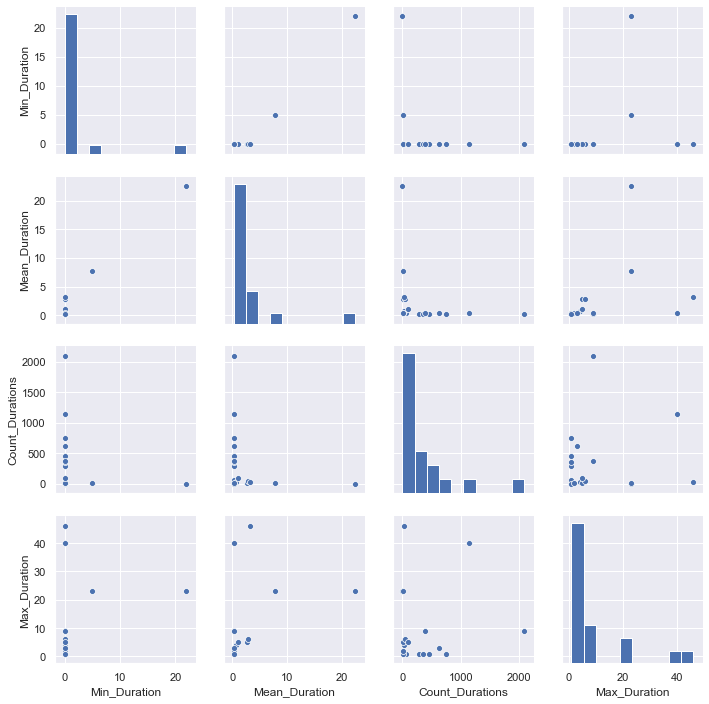

In [89]:
sns.pairplot(data=dur_stats_only_3_mo_day, palette='husl')

## 4. Total health history

#### 4.1 - Total health history stats by month

In [298]:
def prep_monthly_agg_data_sect_4(base_data_hist_w_dates: pd.DataFrame, exclude_weekends: bool) -> pd.DataFrame:
    
    if (exclude_weekends):
        weekday_filter = ( (base_data_hist_w_dates['Weekday'] != 'Saturday') & (base_data_hist_w_dates['Weekday'] != 'Sunday') )
        base_data_hist_w_dates.where(weekday_filter, inplace=True)
        base_data_hist_w_dates.dropna(inplace=True)
    
    # Aggregate Duration for min, max and count over each week (using named aggregation, which drops all non-aggregated, non-index cols):
    month_aggs = base_data_hist_w_dates.groupby(pd.Grouper(freq='M')).agg(
    Min_Duration=pd.NamedAgg(column='Duration', aggfunc='min'),
    Max_Duration=pd.NamedAgg(column='Duration', aggfunc='max'),
    Mean_Duration=pd.NamedAgg(column='Duration', aggfunc=np.mean),
    Count_Durations=pd.NamedAgg(column='Duration', aggfunc='count'),
    First_Day=pd.NamedAgg(column='Day', aggfunc='min'),
    Last_Day=pd.NamedAgg(column='Day', aggfunc='max'),
    Month=pd.NamedAgg(column='Month', aggfunc='max'),
    Year=pd.NamedAgg(column='Year', aggfunc='max')
    #     Weekday=pd.NamedAgg(column='Duration', aggfunc=np.first)
    )
    month_aggs.dropna(inplace=True)
    
    # Add the Month_Label for labeling the plot:
    month_aggs['Month_Label'] = month_aggs['Year'].astype(int).astype(str) + '/' + month_aggs['Month'].astype(int).astype(str) + '\ndays: ' + month_aggs['First_Day'].astype(int).astype(str) + '-' + month_aggs['Last_Day'].astype(int).astype(str)
    #     month_aggs_historical['Year'] = month_aggs_historical['Year'].astype(str)[:4]
    # Drop columns that we only needed temporarily, to create the Week_Label above:
    month_aggs.drop(axis=1, columns=['First_Day', 'Last_Day'], inplace=True)
    
    return month_aggs

In [299]:
# Bring in the data:
month_aggs_historical = prep_monthly_agg_data_sect_4(
    base_data_hist_w_dates=all_requests_dates,
    exclude_weekends=True
)

In [300]:
month_aggs_historical.head()

,Min_Duration,Max_Duration,Mean_Duration,Count_Durations,Month,Year,Month_Label
StartTimeStamp,,,,,,,
2015-01-31,0.0,46.0,0.393094,1506,1.0,2015.0,2015/1\ndays: 19-30
2015-02-28,0.0,40.0,0.296599,4764,2.0,2015.0,2015/2\ndays: 2-23
2015-03-31,0.0,22.0,3.088889,90,3.0,2015.0,2015/3\ndays: 23-30
2015-04-30,0.0,2178484.0,7004.012539,319,4.0,2015.0,2015/4\ndays: 6-23
2015-05-31,0.0,94853.0,272.414085,355,5.0,2015.0,2015/5\ndays: 7-29


#### **Expand cells below to see intermediate results of the DataFrame manipulation above:**

In [237]:
base_data_hist_w_dates = all_requests_dates

# Aggregate Duration for min, max and count over each week (using named aggregation, which drops all non-aggregated, non-index cols):
month_aggs = base_data_hist_w_dates.groupby(pd.Grouper(freq='M')).agg(
Min_Duration=pd.NamedAgg(column='Duration', aggfunc='min'),
Max_Duration=pd.NamedAgg(column='Duration', aggfunc='max'),
#     Mean_Duration=pd.NamedAgg(column='Duration', aggfunc=np.mean),
Count_Durations=pd.NamedAgg(column='Duration', aggfunc='count'),
First_Day=pd.NamedAgg(column='Day', aggfunc='min'),
Last_Day=pd.NamedAgg(column='Day', aggfunc='max'),
Month=pd.NamedAgg(column='Month', aggfunc='max'),
Year=pd.NamedAgg(column='Year', aggfunc='max')
#     Weekday=pd.NamedAgg(column='Duration', aggfunc=np.first)
)
month_aggs.dropna()

month_aggs

,Min_Duration,Max_Duration,Count_Durations,First_Day,Last_Day,Month,Year
StartTimeStamp,,,,,,,
2015-01-31,0.0,46.0,1506,19.0,30.0,1.0,2015.0
2015-02-28,0.0,40.0,4764,2.0,23.0,2.0,2015.0
2015-03-31,0.0,22.0,90,23.0,30.0,3.0,2015.0
2015-04-30,0.0,2178484.0,319,6.0,23.0,4.0,2015.0
2015-05-31,0.0,94853.0,355,7.0,29.0,5.0,2015.0
2015-06-30,0.0,187.0,25,5.0,11.0,6.0,2015.0
2015-07-31,1.0,7.0,31,7.0,13.0,7.0,2015.0
2015-08-31,NaN,NaN,0,NaN,NaN,NaN,NaN
2015-09-30,NaN,NaN,0,NaN,NaN,NaN,NaN


In [238]:
# Do the last aggregation that was left our above with a simple groupby() and save in a second dataframe:
month_agg_mean = base_data_hist_w_dates.groupby('Month', as_index=True).mean()
month_agg_mean = month_agg_mean.rename(columns={'Duration':'Mean_Duration'})
month_agg_mean.drop(axis=1, columns=['Day', 'Week'], inplace=True)
month_agg_mean.dropna(inplace=True) # use this form elsewhere!

month_agg_mean

,Mean_Duration,Year
Month,,
1.0,0.393094,2015.000000
2.0,0.296599,2015.000000
3.0,3.138298,2015.042553
4.0,7004.012539,2015.000000
5.0,272.414085,2015.000000
6.0,17.880000,2015.000000
7.0,4.322581,2015.000000
10.0,1.513043,2015.000000


In [122]:
# Now there are 2 DFs that need to merge:
month_aggs_historical = pd.merge(month_aggs, month_agg_mean, on='Month')
# Add a "Week_Label" column that can be used as a label for the plot, describing the month and the day-range of the given week:
month_aggs_historical.reset_index(inplace=True)
month_aggs_historical['Week_Label'] = month_aggs_historical['Year'].astype(int).astype(str) + '/' + month_aggs_historical['Month'].astype(int).astype(str) + '\ndays: ' + month_aggs_historical['First_Day'].astype(int).astype(str) + '-' + month_aggs_historical['Last_Day'].astype(int).astype(str)
# Drop columns that we only needed temporarily, to create the Week_Label above:
month_aggs_historical.drop(axis=1, columns=['First_Day', 'Last_Day', 'Year'], inplace=True)
month_aggs_historical.set_index('Month', inplace=True)

month_aggs_historical

,Min_Duration,Max_Duration,Count_Durations,Mean_Duration,Week_Label
Month,,,,,
1,0.0,46.0,1606,0.383562,2015/1\ndays: 19-31
2,0.0,40.0,4980,0.292570,2015/2\ndays: 1-23
3,0.0,22.0,94,3.138298,2015/3\ndays: 14-30
4,0.0,2178484.0,380,5879.818421,2015/4\ndays: 5-23
5,0.0,94853.0,404,240.168317,2015/5\ndays: 7-31
6,0.0,984.0,56,28.250000,2015/6\ndays: 5-11
7,1.0,7.0,31,4.322581,2015/7\ndays: 7-13
10,0.0,9.0,147,1.387755,2015/10\ndays: 6-14


**Plot definitions:**

In [61]:
marker_size_4_1 = 100

mean_line_color_4_1 = '#ffaa00'
min_line_color_4_1 = '#54b536'
max_line_color_4_1 = '#bb311b'
count_line_color_4_1 = '#69c7ff'

In [63]:
mon_hist_grid = sns.FacetGrid(row='Year', data=month_aggs_historical, height=3.6, aspect=3.7, legend_out=True)

mon_hist_grid.map(sns.lineplot, 'Month', 'Mean_Duration', color=mean_line_color_4_1, estimator=None)
mon_hist_grid.map(sns.scatterplot, 'Month', 'Mean_Duration', color=mean_line_color_4_1, s=marker_size_4_1)

mon_hist_grid.map(sns.lineplot, 'Month', 'Min_Duration', color=min_line_color_4_1, estimator=None)
mon_hist_grid.map(sns.scatterplot, 'Month', 'Min_Duration', color=min_line_color_4_1, s=marker_size_4_1)

mon_hist_grid.map(sns.lineplot, 'Month', 'Max_Duration', color=max_line_color_4_1, estimator=None)
mon_hist_grid.map(sns.scatterplot, 'Month', 'Max_Duration', color=max_line_color_4_1, s=marker_size_4_1)

mon_hist_grid.map(sns.lineplot, 'Month', 'Count_Durations', color=count_line_color_4_1, estimator=None)
mon_hist_grid.map(sns.scatterplot, 'Month', 'Count_Durations', color=count_line_color_4_1, s=marker_size_4_1)

axes = mon_hist_grid.axes.flatten()

mon_hist_grid.set_ylabels('Request Duration Stats', fontsize=15, labelpad=15)
mon_hist_grid.set_xlabels('Month', fontsize=15, labelpad=15)

set_year_name_axes_titles(axes, month_aggs_historical, 'left')

mon_hist_grid.set(yscale='symlog')  # Retain zero values

mon_hist_grid.set_titles(fontsize=200)

# grid.set_xticklabels('')

mon_hist_grid.fig.subplots_adjust(top=0.8, left=0.125, right=0.997, hspace=0.2)  # These are magic numbers, do not adjust.
mon_hist_grid.fig.suptitle('Mean, Min, Max and Count of Request Durations by Month (to-Date)', fontsize=20)

mon_hist_grid.fig.legend(handles=(axes[0].lines[3], axes[0].lines[2], axes[0].lines[1], axes[0].lines[0]), labels=('Request Load/Count', 'Max Req. Duration', 'Min Req. Duration', 'Mean Req. Duration'), borderpad=0.5, labelspacing=0.8, fontsize=13, loc='upper right')

# grid.axes[i].tick_params(axis='both', which='major', labelsize=15)

# Settings that need to be applied to each axis:
for i in range(len(axes)):
    axes[i].set_xticklabels(month_aggs_historical['Month_Label'], rotation=45)
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].set_ylim(bottom=-0.5)  # 0 doesn't work... 

NameError: name 'month_aggs_historical' is not defined

#### 4.2 - Total health history stats by week

In [25]:
import seaborn as sns

In [39]:
def prep_weekly_agg_data_sect_4(base_data_hist_w_dates: pd.DataFrame, exclude_weekends: bool) -> pd.DataFrame:
    
    if (exclude_weekends):
        weekday_filter = ( (base_data_hist_w_dates['Weekday'] != 'Saturday') & (base_data_hist_w_dates['Weekday'] != 'Sunday') )
        base_data_hist_w_dates.where(weekday_filter, inplace=True)
        base_data_hist_w_dates.dropna(inplace=True)
    
    # Aggregate Duration for min, max and count over each week (using named aggregation, which drops all non-aggregated, non-index cols):
    week_aggs = base_data_hist_w_dates.groupby(pd.Grouper(freq='W')).agg(
    Min_Duration=pd.NamedAgg(column='Duration', aggfunc='min'),
    Max_Duration=pd.NamedAgg(column='Duration', aggfunc='max'),
    Mean_Duration=pd.NamedAgg(column='Duration', aggfunc=np.mean),
    Count_Durations=pd.NamedAgg(column='Duration', aggfunc='count'),
    First_Day=pd.NamedAgg(column='Day', aggfunc='min'),
    Last_Day=pd.NamedAgg(column='Day', aggfunc='max'),
    Week=pd.NamedAgg(column='Week', aggfunc='max'),
    Month=pd.NamedAgg(column='Month', aggfunc='max'),
    Year=pd.NamedAgg(column='Year', aggfunc='max')
    #     Weekday=pd.NamedAgg(column='Duration', aggfunc=np.first)
    )
    week_aggs.dropna(inplace=True)
    
    # Add the Month_Label for labeling the plot:
    week_aggs['Week_Label'] = week_aggs['Year'].astype(int).astype(str) + '/' + week_aggs['Month'].astype(int).astype(str) + '\ndays: ' + week_aggs['First_Day'].astype(int).astype(str) + '-' + week_aggs['Last_Day'].astype(int).astype(str)
    #     month_aggs_historical['Year'] = month_aggs_historical['Year'].astype(str)[:4]
    # Drop columns that we only needed temporarily, to create the Week_Label above:
    week_aggs.drop(axis=1, columns=['First_Day', 'Last_Day'], inplace=True)
    
    return week_aggs

In [40]:
# RUN THIS CELL TO RESET DATA:
wk_aggs_historical = prep_weekly_agg_data_sect_4(
    base_data_hist_w_dates=all_requests_dates,
    exclude_weekends=True
)

In [42]:
wk_aggs_historical.head()

,Min_Duration,Max_Duration,Mean_Duration,Count_Durations,Week,Month,Year,Week_Label
StartTimeStamp,,,,,,,,
2015-01-25,0.0,4.0,0.625000,32,4.0,1.0,2015.0,2015/1\ndays: 19-22
2015-02-01,0.0,46.0,0.388060,1474,5.0,1.0,2015.0,2015/1\ndays: 26-30
2015-02-08,0.0,40.0,0.277457,4325,6.0,2.0,2015.0,2015/2\ndays: 2-6
2015-02-15,0.0,23.0,0.433790,438,7.0,2.0,2015.0,2015/2\ndays: 9-11
2015-03-01,23.0,23.0,23.000000,1,9.0,2.0,2015.0,2015/2\ndays: 23-23


**Plot definitions:**

In [57]:
marker_size_4_2 = 60

mean_line_color_4_2 = '#ffaa00'
min_line_color_4_2 = '#54b536'
max_line_color_4_2 = '#bb311b'
count_line_color_4_2 = '#69c7ff'

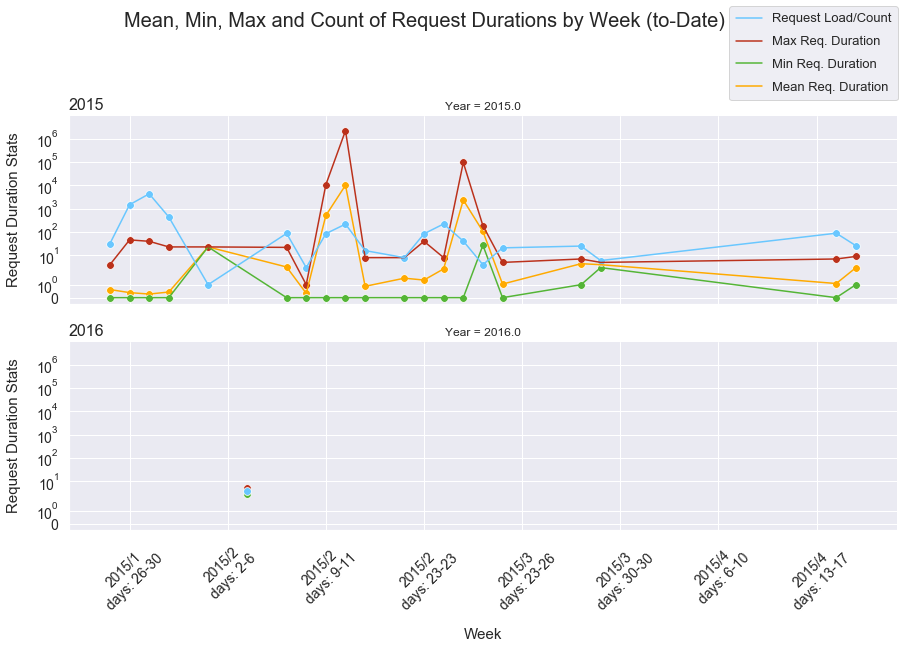

In [60]:
sns.set(style='darkgrid')

wk_hist_grid = sns.FacetGrid(row='Year', data=wk_aggs_historical, height=4, aspect=3.3, legend_out=True)

wk_hist_grid.map(sns.lineplot, 'Week', 'Mean_Duration', color=mean_line_color_4_2, estimator=None)
wk_hist_grid.map(sns.scatterplot, 'Week', 'Mean_Duration', color=mean_line_color_4_2, s=marker_size_4_2)

wk_hist_grid.map(sns.lineplot, 'Week', 'Min_Duration', color=min_line_color_4_2, estimator=None)
wk_hist_grid.map(sns.scatterplot, 'Week', 'Min_Duration', color=min_line_color_4_2, s=marker_size_4_2)

wk_hist_grid.map(sns.lineplot, 'Week', 'Max_Duration', color=max_line_color_4_2, estimator=None)
wk_hist_grid.map(sns.scatterplot, 'Week', 'Max_Duration', color=max_line_color_4_2, s=marker_size_4_2)

wk_hist_grid.map(sns.lineplot, 'Week', 'Count_Durations', color=count_line_color_4_2, estimator=None)
wk_hist_grid.map(sns.scatterplot, 'Week', 'Count_Durations', color=count_line_color_4_2, s=marker_size_4_2)

axes = wk_hist_grid.axes.flatten()

wk_hist_grid.set_ylabels('Request Duration Stats', fontsize=15, labelpad=15)
wk_hist_grid.set_xlabels('Week', fontsize=15, labelpad=15)

set_year_name_axes_titles(axes, wk_aggs_historical, 'left')

wk_hist_grid.set(yscale='symlog')  # Retain zero values

wk_hist_grid.set_titles(fontsize=200)

# grid.set_xticklabels('')

wk_hist_grid.fig.subplots_adjust(top=0.8, left=0.125, right=0.997, hspace=0.2)  # These are magic numbers, do not adjust.
wk_hist_grid.fig.suptitle('Mean, Min, Max and Count of Request Durations by Week (to-Date)', fontsize=20)

wk_hist_grid.fig.legend(handles=(axes[0].lines[3], axes[0].lines[2], axes[0].lines[1], axes[0].lines[0]), labels=('Request Load/Count', 'Max Req. Duration', 'Min Req. Duration', 'Mean Req. Duration'), borderpad=0.5, labelspacing=0.8, fontsize=13, loc='upper right')

# grid.axes[i].tick_params(axis='both', which='major', labelsize=15)

# Settings that need to be applied to each axis:
for i in range(len(axes)):
    axes[i].set_xticklabels(wk_aggs_historical['Week_Label'], rotation=45)
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].set_ylim(bottom=-0.5)  # 0 doesn't work... 